In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19


# Dataset Loading and Splitting



In [2]:
base_ds = '/home/ines/Downloads/Rice_Image_Dataset(2)/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [3]:
base_ds

PosixPath('/home/ines/Downloads/Rice_Image_Dataset(2)/Rice_Image_Dataset')

In [4]:
#split imgs
import splitfolders
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

In [5]:
#listdir returns everything in directory
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

# Dataset Exploration

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


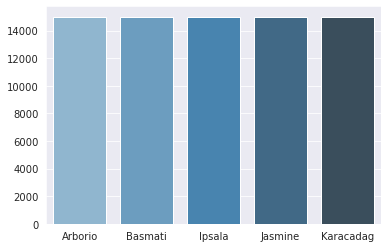

In [6]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

Image dimensions: (250, 250, 3)


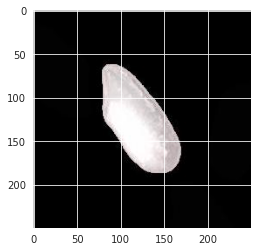

In [7]:
sample_img = cv2.imread('imgs/test/Arborio/Arborio (10).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [8]:


def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')



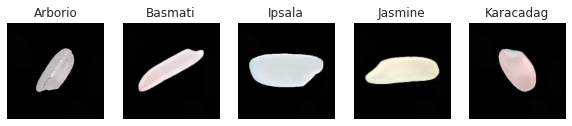

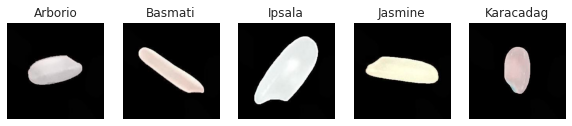

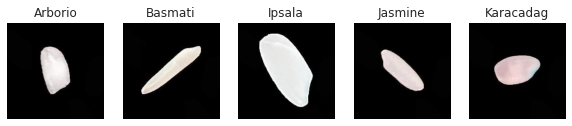

In [9]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

In [33]:
#batch size = 100: takes from 1st to 100th sample in training and trains, then 101st to 200th..
#if training not divisible by batch without remainder, set batch to 100+remainder
#batch < pop: requires less memory
#types like in gd
batch_size = 64
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)



# Data Pre-processing

In [34]:
#data aug: techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting 
#Generate batches of tensor image data with real-time data augmentation
#rescale: data * value
#validation data should not be augmented
datagen = ImageDataGenerator(rescale=1./255)

In [35]:
#flow from dir when train_ds test_ds and val_ds
train_ds = datagen.flow_from_directory(
    #dir
    'imgs/train',
    #resize
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    #binary labels for categorical_crossentropy loss
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 54003 images belonging to 7 classes.
Found 11571 images belonging to 7 classes.
Found 11574 images belonging to 7 classes.


# Transfer Learning

In [36]:
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
vgg19.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg19(inputs, training=False)
#GlobalAveragePooling2D: downsample an input by taking the average value along the spatial dimensions and return a 1D output by default
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg19 = tf.keras.Model(inputs, x)

In [37]:
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 20,554,821
Trainable params: 530,437
Non-trainable params: 20,024,384
_________________________________________

In [41]:
#save model
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg19.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
#regularization used to avoid overfitting when training a learner with an iterative method
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
#reducing the learning rate by a factor of 2-10 once learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
#save early stopping, reducd lr and checkpnter
callbacks=[early_stopping, reduce_lr, checkpointer]

In [39]:
history = model_vgg19.fit(train_ds, epochs = 12, validation_data = val_ds, callbacks=callbacks)

Epoch 1/12


2022-12-26 02:08:44.711153: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 346.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-26 02:08:44.711259: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 346.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-26 02:08:44.711324: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-26 02:08:44.711363: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator 

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4463/765831513.py", line 1, in <cell line: 1>
      history = model_vgg19.fit(train_ds, epochs = 12, validation_data = val_ds, callbacks=callbacks)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5538, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[64,5] labels_size=[64,7]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_5296]